# Correlation features
the idea is to use cross correlation among time series, as we did for the ROIs.



In [3]:
%load_ext autoreload
%autoreload 2
from util import to_corr_matrix,to_matrix

import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df_train = pd.read_csv('data\\train.csv')
# df_train.to_parquet('train.parquet')
# df_train = pd.read_parquet('train.parquet')
df_ts = df_train.iloc[:,5:] # timeseries features only
df_train['y_s'] = df_train.y > 1


Get names for the correlation features

In [14]:
regions = df_ts.columns.str.extract(r'(\w\d\w)\d{1,4}')[0].unique()
cross_names = [regions[i]+'x'+regions[j] for i in range(24) for j in range(i+1,24)]

compute the correlation features:

In [15]:
def to_corr_features(features):
    '''transforms a df row into a df row of correlations'''
    upper_triangular_idx = np.triu_indices(24, k=1)

    cor_mat = features\
                .apply(to_corr_matrix, axis=1)\
                .apply(lambda x: x[upper_triangular_idx])\
                .values

    return pd.DataFrame(np.vstack(cor_mat), columns = cross_names)


X = to_corr_features(df_ts)
X

,E1AxE1H,E1AxE1P,E1AxE1V,E1AxE2A,E1AxE2H,E1AxE2P,E1AxE2V,E1AxE3A,E1AxE3H,E1AxE3P,...,M1VxM2A,M1VxM2H,M1VxM2P,M1VxM2V,M2AxM2H,M2AxM2P,M2AxM2V,M2HxM2P,M2HxM2V,M2PxM2V
0,0.192835,0.000725,0.043907,-0.137231,0.063441,-0.013192,0.198359,0.014956,0.050120,0.006809,...,-0.145882,0.020524,0.005138,0.044293,-0.222560,0.020593,-0.030588,-0.021597,0.063249,0.009557
1,0.083252,0.010042,0.311112,-0.132368,0.018960,-0.049720,0.026321,-0.332948,-0.077096,-0.038908,...,-0.310129,-0.099840,-0.040385,-0.085318,0.077788,-0.009852,-0.225882,0.001466,0.080818,0.036665
2,0.349673,0.011953,-0.413327,-0.293103,-0.015739,0.015867,-0.086237,-0.016873,-0.023048,-0.005212,...,-0.043495,0.083354,-0.006703,0.050723,-0.112527,-0.017907,-0.282990,-0.029487,0.088341,0.033712
3,-0.179964,0.006704,-0.566549,0.043433,0.002825,0.023454,-0.183878,-0.042051,0.049118,0.008525,...,0.033051,0.095204,0.015089,-0.031048,0.432608,-0.026737,-0.078006,0.006790,-0.065090,0.011237
4,0.444582,0.001509,0.244129,0.087876,0.141928,0.004871,-0.231792,-0.036350,-0.034943,-0.000716,...,0.131249,0.168303,-0.023282,-0.023969,0.307061,0.008753,0.194387,0.019034,-0.031796,0.028717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,-0.126427,0.000022,0.240387,0.221170,0.038086,0.004444,0.071129,-0.151660,0.061491,0.009133,...,0.220329,-0.027507,0.011410,-0.415687,-0.118325,0.012536,-0.092691,-0.017104,0.274723,-0.018170
659,0.138915,0.010996,-0.478739,0.221996,-0.075953,0.010246,-0.186881,-0.102893,-0.013455,-0.004142,...,0.238597,-0.053095,-0.002734,0.294956,-0.266500,0.003545,0.597507,0.002204,-0.175788,-0.028948
660,0.028611,-0.014615,-0.255867,0.040209,-0.057809,-0.002629,0.114954,-0.023344,-0.025749,-0.027485,...,0.110337,-0.034137,0.029198,0.150747,-0.145211,0.005429,0.570585,0.054239,-0.124445,0.017022
661,-0.262847,0.023493,-0.254257,0.197271,-0.032240,0.010279,-0.088650,0.018426,0.029782,0.018438,...,0.404627,0.188908,-0.019506,0.108286,-0.220473,-0.026637,-0.104047,0.002287,0.098435,0.005906


## Fit Model

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df_train.y_s, test_size=0.3, stratify=df_train.y_s)
# first we split data stratifying to assure a balanced number of classess

In [18]:
from sklearn.svm import LinearSVC

model = LinearSVC(class_weight='balanced')

model.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

0.43548387096774194

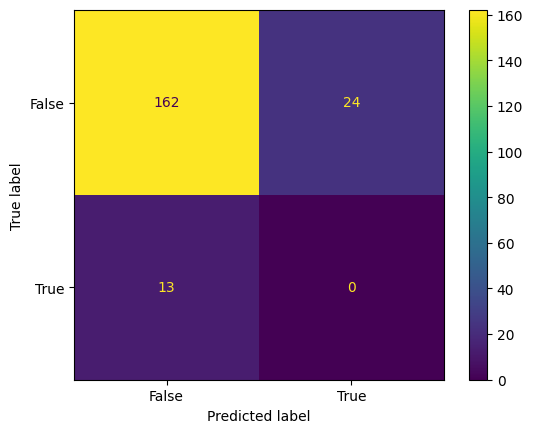

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score

y_hat = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
balanced_accuracy_score(y_test, y_hat)

The results are very very bad

## Population summaries

In [ ]:
x = df_train.iloc[1,5:]

x.values.reshape(24,2048)

summaries = [
    np.max,
    np.min,
    np.mean,
    lambda x: np.quantile(x, q=0.05),
    lambda x: np.quantile(x,q=0.25),
    lambda x: np.quantile(x,q=0.75),
    lambda x:np.quantile(x,q=0.5),
    lambda x: np.quantile(x,q=0.95),
    np.std
]

X = df_train.iloc[:,5:].values.reshape(663,24,2048)
X = [np.concatenate([np.apply_along_axis(i,1,row) for i in summaries]) for row in X]
df_train.y = df_train.y == 1

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, df_train.y, test_size=0.3, stratify=df_train.y)
model = SVC(C=2, class_weight='balanced')
model.fit(x_train,y_train)

SVC(C=2, class_weight='balanced')

In [ ]:
from sklearn.metrics import confusion_matrix
y_hat = model.predict(x_test)
confusion_matrix(y_test,y_hat),balanced_accuracy_score(y_test, y_hat), y_test.mean()

(array([[ 7,  6],
        [98, 88]], dtype=int64),
 0.5057899090157154,
 0.9346733668341709)

# Submission

In [ ]:
model_final = SVC(C=2, class_weight='balanced')
model_final.fit(X, df_train.y)

SVC(C=2, class_weight='balanced')

In [ ]:
df_sub = pd.read_csv('test.csv')

In [ ]:
df_sub


,id,main.pos,fun.pos,when,E1A1,E1A2,E1A3,E1A4,E1A5,E1A6,...,M2V2039,M2V2040,M2V2041,M2V2042,M2V2043,M2V2044,M2V2045,M2V2046,M2V2047,M2V2048
0,8,LHCB-6,QSCB-6-CP2,2023-01,0.044012,-0.042142,-0.360478,-0.388143,-0.234347,0.008777,...,0.145522,-0.367679,0.032325,0.351489,-0.191679,-0.238662,0.362742,0.046373,-0.353114,0.144611
1,11,LHCB-8,QSCB-8-CP2,2023-03,0.354656,-0.258057,-0.435417,0.105555,0.306157,0.133404,...,-0.209803,-0.317693,-0.123496,0.213077,0.269170,0.270980,-0.004193,-0.321301,-0.250778,-0.114053
2,12,LHCB-4,QSCB-4-CP2,2018-10,-0.072705,0.136741,0.098616,0.292389,0.169617,0.270838,...,0.169434,0.403928,0.340472,0.022822,-0.110036,0.275612,0.503778,0.373271,0.008208,-0.096481
3,13,LHCB-4,QSCB-4-CP6,2018-07,0.776889,0.264793,1.252166,0.038967,0.915882,0.264486,...,-0.303733,-0.003635,-0.152131,-0.214604,0.067547,-0.139258,0.134942,0.715979,-0.044375,-0.040361
4,15,LHCB-P18,QSCB-18-C2,2017-09,0.767639,1.278452,-1.360223,0.214819,-0.767639,0.574346,...,0.102140,-0.055244,0.151701,-0.126399,0.191852,-0.127218,0.298706,-0.073931,0.208696,-0.041512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,995,LHCB-8,QSCB-8-CP7,2018-06,-1.780864,1.005961,0.224570,0.168402,-0.247760,-0.679507,...,0.097810,0.109827,0.124577,-0.092804,-0.010326,0.332883,0.545942,0.373944,0.113656,-0.187434
351,997,LHCB-4,QSCB-4-CP6,2021-11,-0.727646,-0.121540,0.159425,0.625580,-0.352326,-0.139818,...,-0.074978,-0.307108,-0.182105,0.375124,0.283892,0.454548,0.262555,0.494833,0.296610,0.043673
352,1003,LHCB-8,QSCB-8-CP1,2022-05,0.101757,0.175610,0.377732,0.585461,0.144735,0.253156,...,0.066182,0.063941,0.091446,0.066662,0.032533,0.055569,-0.026244,-0.040686,-0.011396,-0.022452
353,1016,LHCB-P18,QSCB-18-C6,2022-08,0.917198,1.665725,2.534468,1.889459,0.023705,-1.054286,...,-0.123601,0.429097,-0.424900,-0.112483,-0.047660,0.056007,-0.392076,0.248702,-0.534772,0.030336


In [ ]:
X_sub = df_sub.iloc[:,4:].values.reshape(355,24,2048)
X_sub = [np.concatenate([np.apply_along_axis(i,1,row) for i in summaries]) for row in X_sub]

In [ ]:
y_sub = model_final.predict(X_sub)
submission_df = pd.DataFrame(y_sub,columns=['y'])
submission_df['id'] = df_sub.id
submission_df.set_index('id', inplace=True)
submission_df.y = 2-submission_df.y
submission_df.to_csv('submission.csv')